In [47]:
# #To be used on cloud platforms

# ! python -c "import pykeen" || pip install pykeen
# ! python -c "import scprep" || pip install scprep

In [48]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD
import rpy2, rpy2.situation, anndata2ri


In [49]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab


# Prep

## Load scRNAseq data

We will have to use rpy to import the seurat object with the data. From there we already have code (from RNA Velo NBs) to extract metadata. Need to extract count matrices.

In [50]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/c

In [51]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [52]:
%%R -i data_dir
library(tidyverse)
library(Seurat)

paste0(data_dir)

[1] "/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab/data"


In [53]:
%%R -o dGenesSeq,dRnaSeq,dftest

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Get genes present in Seurat object
dGenesSeq = rownames(d_fibWT@assays$RNA@data)
#Convert seurat object to anndata
dRnaSeq = as.SingleCellExperiment(d_fibWT)
#Export PHATE coordinates
dftest = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))

rm(d_fibWT)

An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


Export list of genes detected in scRNA-seq dataset.
This will be used to subset the Knowledge Graph

In [54]:
len(list(dGenesSeq))

20867

In [55]:
print(dRnaSeq.var_names)
print(dRnaSeq.obs)
print(dRnaSeq.obsm)#No DimRed were ported over
dRnaSeq

Index(['Xkr4', 'Gm37363', 'Gm6123', 'Mrpl15', 'Gm37144', 'Lypla1', 'Gm37988',
       'Tcea1', 'Rgs20', 'Atp6v1h',
       ...
       'mt-Tg', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb',
       'mt-Tt', 'partDsRedE', 'pEGFP'],
      dtype='object', length=20867)
                         orig.ident  nCount_RNA  nFeature_RNA  mito_content  \
WT__AAACCCACAGCTTCCT-1  cocultWTFib     10761.0          3163      0.947867   
WT__AAACCCAGTTCGAGCC-1  cocultWTFib     15485.0          3811      1.233452   
WT__AAACGAAAGAAGGATG-1  cocultWTFib     16689.0          3775      1.270298   
WT__AAACGAAAGGAAAGGT-1  cocultWTFib      5756.0          2126      1.476720   
WT__AAACGAAAGTTAACGA-1  cocultWTFib     40330.0          4714      0.451277   
...                             ...         ...           ...           ...   
WT__TTTGGTTTCATTCTTG-1  cocultWTFib      9953.0          2555      0.351653   
WT__TTTGGTTTCCGTAGTA-1  cocultWTFib     15622.0          3810      1.389067   
WT__TTTGTT

AnnData object with n_obs × n_vars = 3698 × 20867
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    layers: 'logcounts'

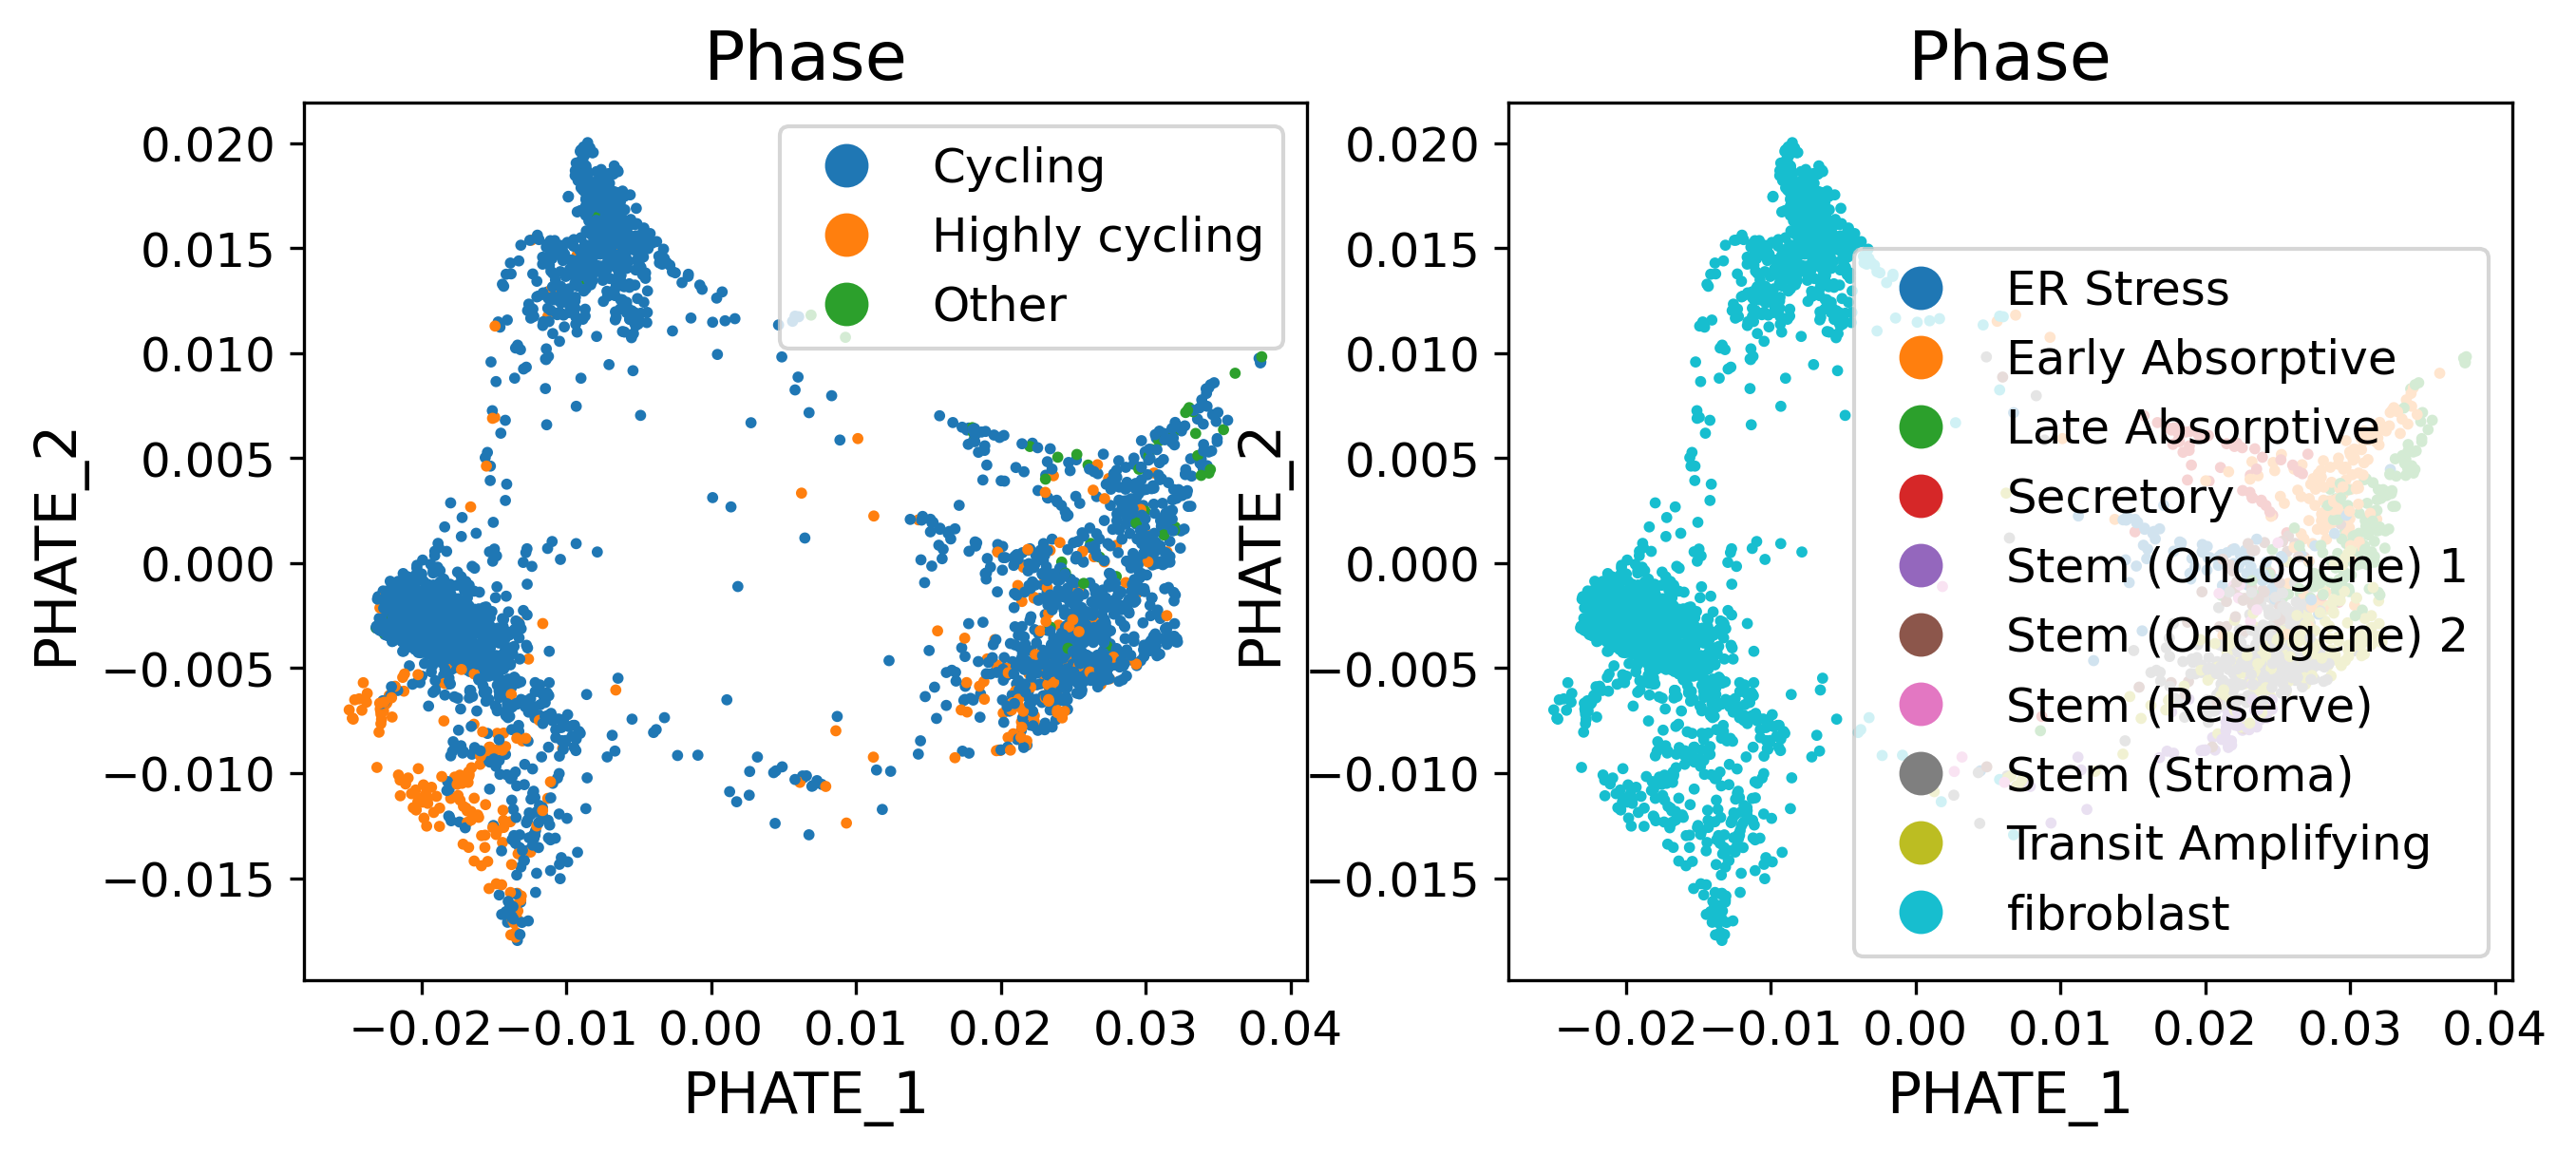

In [56]:
#Add phate dims and view
dRnaSeq.obsm["X_PHATE"] = dftest

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.Phase, figsize=(4.8,3),
                     title=f"Phase", ax=ax[0])
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(4.8,3),
                     title=f"Phase", ax=ax[1])

del dftest

View data from AnnData object layers as dataframes.

In [57]:
print(dRnaSeq.to_df().head()) #Untransformed data
dRnaSeq.to_df(layer="logcounts").head() #Log transformed data to be used

                        Xkr4  Gm37363  Gm6123  Mrpl15  Gm37144  Lypla1  \
WT__AAACCCACAGCTTCCT-1   0.0      0.0     0.0     0.0      0.0     0.0   
WT__AAACCCAGTTCGAGCC-1   0.0      0.0     0.0     0.0      0.0     0.0   
WT__AAACGAAAGAAGGATG-1   0.0      0.0     0.0     0.0      0.0     0.0   
WT__AAACGAAAGGAAAGGT-1   0.0      0.0     0.0     0.0      0.0     0.0   
WT__AAACGAAAGTTAACGA-1   0.0      0.0     0.0     7.0      0.0     0.0   

                        Gm37988  Tcea1  Rgs20  Atp6v1h  ...  mt-Tg  mt-Nd3  \
WT__AAACCCACAGCTTCCT-1      0.0    2.0    0.0      0.0  ...    0.0     1.0   
WT__AAACCCAGTTCGAGCC-1      0.0    2.0    0.0      1.0  ...    0.0     1.0   
WT__AAACGAAAGAAGGATG-1      0.0    0.0    0.0      1.0  ...    0.0     3.0   
WT__AAACGAAAGGAAAGGT-1      0.0    0.0    0.0      0.0  ...    0.0     0.0   
WT__AAACGAAAGTTAACGA-1      0.0    2.0    0.0      2.0  ...    0.0     0.0   

                        mt-Nd4l  mt-Nd4  mt-Nd5  mt-Nd6  mt-Cytb  mt-Tt  \
WT__AAACCCA

,Xkr4,Gm37363,Gm6123,Mrpl15,Gm37144,Lypla1,Gm37988,Tcea1,Rgs20,Atp6v1h,...,mt-Tg,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,mt-Tt,partDsRedE,pEGFP
WT__AAACCCACAGCTTCCT-1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1.050319,0.0,0.000000,...,0.0,0.657148,0.000000,2.571135,0.000000,0.000000,3.988411,0.0,0.657148,0.0
WT__AAACCCAGTTCGAGCC-1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.829238,0.0,0.498218,...,0.0,0.498218,0.000000,2.948746,1.077511,0.000000,4.079582,0.0,0.000000,0.0
WT__AAACGAAAGAAGGATG-1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.469502,...,0.0,1.028759,0.469502,2.563713,1.028759,0.000000,4.148146,0.0,0.000000,0.0
WT__AAACGAAAGGAAAGGT-1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,2.811561,1.826475,0.000000,3.474191,0.0,0.000000,0.0
WT__AAACGAAAGTTAACGA-1,0.0,0.0,0.0,1.00638,0.0,0.0,0.0,0.402734,0.0,0.402734,...,0.0,0.000000,0.000000,1.698031,0.911369,0.221506,2.780384,0.0,0.000000,0.0


## KG DataBase

The integrated database is the object ingested by pykeen's *TriplesFactory*.

Then, once the scRNAseq has been loaded in, we can also subset the genes in 
this dataframe to those present in the scRNA-seq count matrix.

In [58]:
dEdgeList = pd.read_csv(f"{data_dir}/dINT_simpl.tsv", sep="\t", header=None)[[0,2]]
print(dEdgeList.shape)

#Filter rows if either column not in sequencing data
dEdgeList = dEdgeList.loc[dEdgeList[0].isin(list(dGenesSeq)) & dEdgeList[2].isin(list(dGenesSeq))]
print(dEdgeList.shape)


(439023, 2)
(348028, 2)


View networkX graph object and show key graph metrics [info(), ...]

In [59]:
G = networkx.from_pandas_edgelist(dEdgeList, 0, 2)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
      networkx.number_of_isolates(G))
print("The graph is connected:",
     networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

/tmp/ipykernel_185852/2064377355.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


Graph with 12229 nodes and 173650 edges, with a density of 0.0023225143619393005
We have this many isolates:  0
The graph is connected: False

We have 99 connected subgraphs
Component 1: Graph with 12018 nodes and 173536 edges, with a density of 0.002403207759440698
Component 2: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 3: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 4: Graph with 3 nodes and 2 edges, with a density of 0.6666666666666666
Component 5: Graph with 3 nodes and 2 edges, with a density of 0.6666666666666666
Component 6: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 7: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 8: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 9: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 10: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 11: Graph with 3 nodes and 3 edges, with a density of 1.0
Component 12: Graph with 2 node

/tmp/ipykernel_185852/2064377355.py:14: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")


In [60]:
# networkx.draw(Gcomponents[0])

## Process scRNA data

### Normalise and denoise gene expression data

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Then subset to genes present in KG.
Then normalise so that the gene expression distributions are equally big for each cell.

We will compute MAGIC with default knn-related params (and not giving it a precomputed graph) and using all genes. However, with the `genes` argument, one should be able to return a processed matrix with only the genes present in the KG (whil still leveraging allthe full suite of genes in the dataset)

In [61]:
#MAGIC
magic_op = magic.MAGIC(
    knn=5, # knn_max set to 3*knn by default
    knn_dist="euclidean",
    decay=1, t=3, n_pca=100, random_state=12,
    n_jobs=-2 #All but one
                      )

In [62]:
help(magic.MAGIC())

Help on MAGIC in module magic.magic object:

class MAGIC(sklearn.base.BaseEstimator)
 |  MAGIC(knn=5, knn_max=None, decay=1, t=3, n_pca=100, solver='exact', knn_dist='euclidean', n_jobs=1, random_state=None, verbose=1)
 |  
 |  MAGIC operator which performs dimensionality reduction.
 |  
 |  Markov Affinity-based Graph Imputation of Cells (MAGIC) is an
 |  algorithm for denoising and transcript recover of single cells
 |  applied to single-cell RNA sequencing data, as described in
 |  van Dijk et al, 2018 [1]_.
 |  
 |  Parameters
 |  ----------
 |  
 |  knn : int, optional, default: 5
 |      number of nearest neighbors from which to compute kernel bandwidth
 |  
 |  knn_max : int, optional, default: None
 |      maximum number of nearest neighbors with nonzero connection.
 |      If `None`, will be set to 3 * `knn`
 |  
 |  decay : int, optional, default: 1
 |      sets decay rate of kernel tails.
 |      If None, alpha decaying kernel is not used
 |  
 |  t : int, optional, default:

In [63]:
# #Original approach was to get all nodes in Knowledge Graph
# gKG = dEdgeList.melt()["value"].drop_duplicates()

#Use instead nodes in 1st connected KG component

In [64]:
dMagicRnaSeq = magic_op.fit_transform(
    X = dRnaSeq.to_df(layer="logcounts"),
    genes = list(Gcomponents[0].nodes())
)
dMagicRnaSeq

Calculating MAGIC...
  Running MAGIC on 3698 cells and 20867 genes.
  Calculating graph and diffusion operator...


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculating PCA...
    Calculated PCA in 4.14 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.43 seconds.
    Calculating affinities...
    Calculated affinities in 2.40 seconds.
  Calculated graph and diffusion operator in 9.46 seconds.
  Running MAGIC with `solver='exact'` on 12018-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 2.77 seconds.
Calculated MAGIC in 88.43 seconds.


,Xkr4,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Alkal1,Rrs1,Adhfe1,...,mt-Co2,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb
WT__AAACCCACAGCTTCCT-1,0.000000,0.656307,0.127007,0.563809,0.000181,0.280992,0.297311,0.074294,0.389065,0.311515,...,0.040082,0.331522,0.222011,0.170977,0.432377,0.042551,2.561046,0.880641,0.083873,3.903000
WT__AAACCCAGTTCGAGCC-1,0.000000,0.675546,0.143338,0.621581,0.000004,0.330037,0.303913,0.048735,0.452445,0.235830,...,0.042243,0.371617,0.227084,0.139289,0.449829,0.045445,2.519365,0.852075,0.078669,3.914076
WT__AAACGAAAGAAGGATG-1,0.000000,0.592672,0.118198,0.463123,0.000037,0.248782,0.276751,0.078990,0.357646,0.293478,...,0.036208,0.318392,0.233965,0.168486,0.399834,0.068342,2.506547,0.912861,0.056959,3.858060
WT__AAACGAAAGGAAAGGT-1,0.000000,0.372321,0.450278,0.207707,0.002779,0.177921,0.179666,0.000000,0.029587,0.000000,...,0.062142,0.220886,0.163329,0.210057,0.120561,0.009209,1.835944,0.843989,0.031708,2.537386
WT__AAACGAAAGTTAACGA-1,0.001376,0.653948,0.318248,0.318942,0.010842,0.145051,0.141733,0.001585,0.106739,0.001012,...,0.046502,0.217982,0.168517,0.128289,0.052599,0.036702,1.888961,0.703151,0.053150,3.189778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.000000,0.484435,0.207535,0.521919,0.018330,0.387812,0.133705,0.000013,0.080484,0.000161,...,0.063694,0.146702,0.083146,0.077182,0.093548,0.006015,1.220427,0.757026,0.083483,2.117314
WT__TTTGGTTTCCGTAGTA-1,0.000000,0.574820,0.161695,0.522491,0.000098,0.246057,0.324671,0.070717,0.390850,0.393462,...,0.050908,0.420381,0.272601,0.206184,0.447587,0.069179,2.618978,1.159805,0.069928,3.866195
WT__TTTGTTGTCGCTTGAA-1,0.000016,0.403741,0.391600,0.321726,0.003814,0.185810,0.204476,0.000129,0.051956,0.000260,...,0.054623,0.275880,0.188689,0.190669,0.076272,0.023582,1.949260,0.808865,0.059552,3.012173
WT__TTTGTTGTCTGAATCG-1,0.000000,0.772078,0.153105,0.622268,0.009051,0.404417,0.286483,0.088398,0.350856,0.033717,...,0.050711,0.323334,0.197531,0.155903,0.347547,0.037113,2.426871,0.708863,0.087412,3.921434


View gene-gene scatter for cycle, fibro and epi genes b4 and after MAGIC

In [65]:
print("Cd44" in dMagicRnaSeq.columns)
print("Fabp2" in dMagicRnaSeq.columns)
print("Epcam" in dMagicRnaSeq.columns)

True
True
True


In [66]:
print("Pdgfra" in dMagicRnaSeq.columns)
print("Cd34" in dMagicRnaSeq.columns)
print("Thy1" in dMagicRnaSeq.columns)

True
True
True


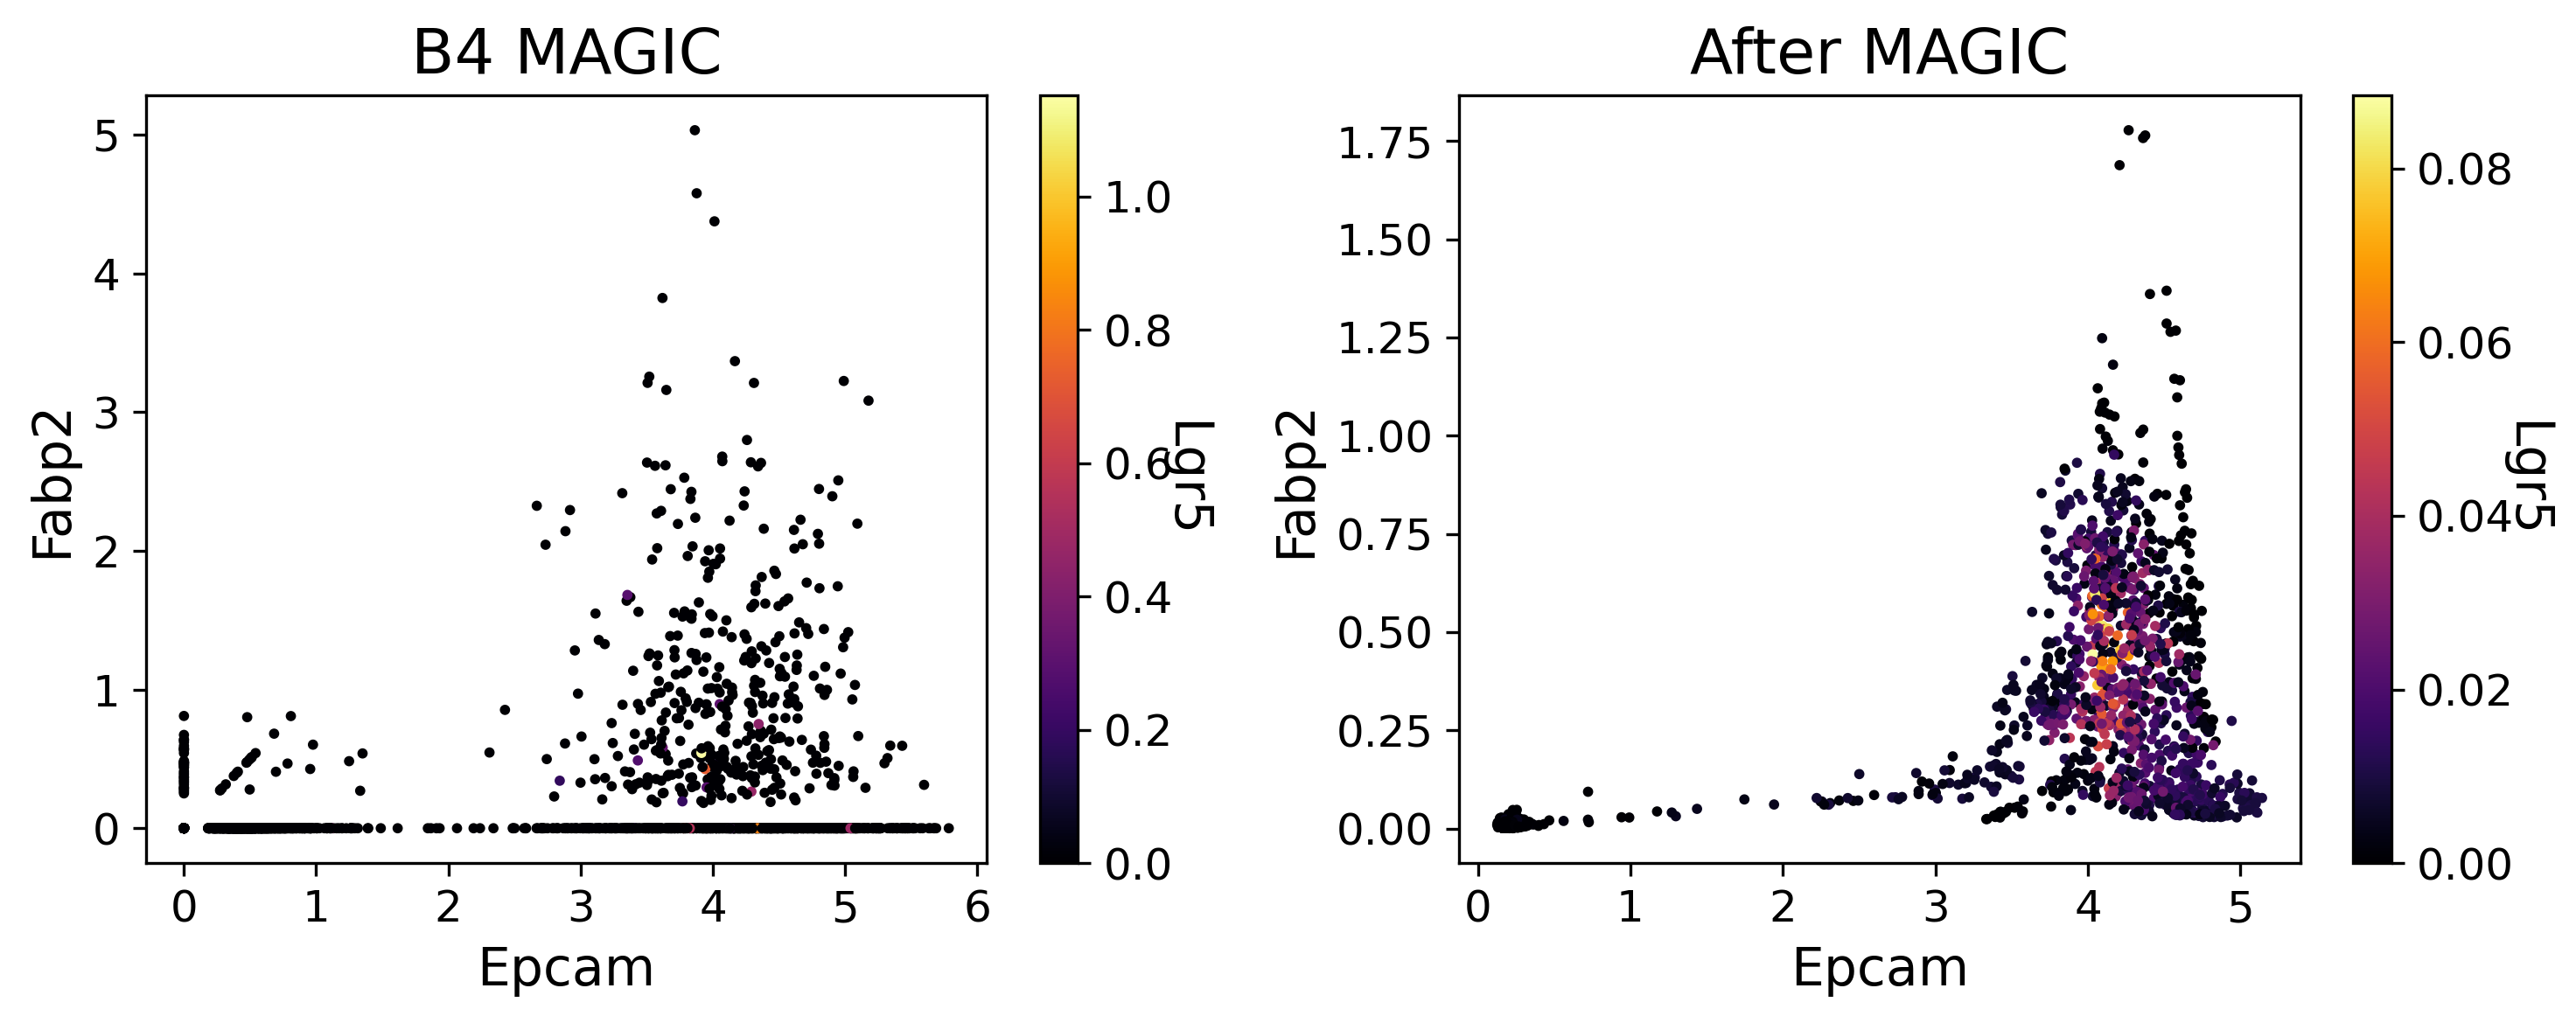

In [67]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq.to_df(layer="logcounts")["Epcam"], y=dRnaSeq.to_df(layer="logcounts")["Fabp2"], c=dRnaSeq.to_df(layer="logcounts")["Lgr5"],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq["Epcam"], y=dMagicRnaSeq["Fabp2"], c=dMagicRnaSeq["Lgr5"],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

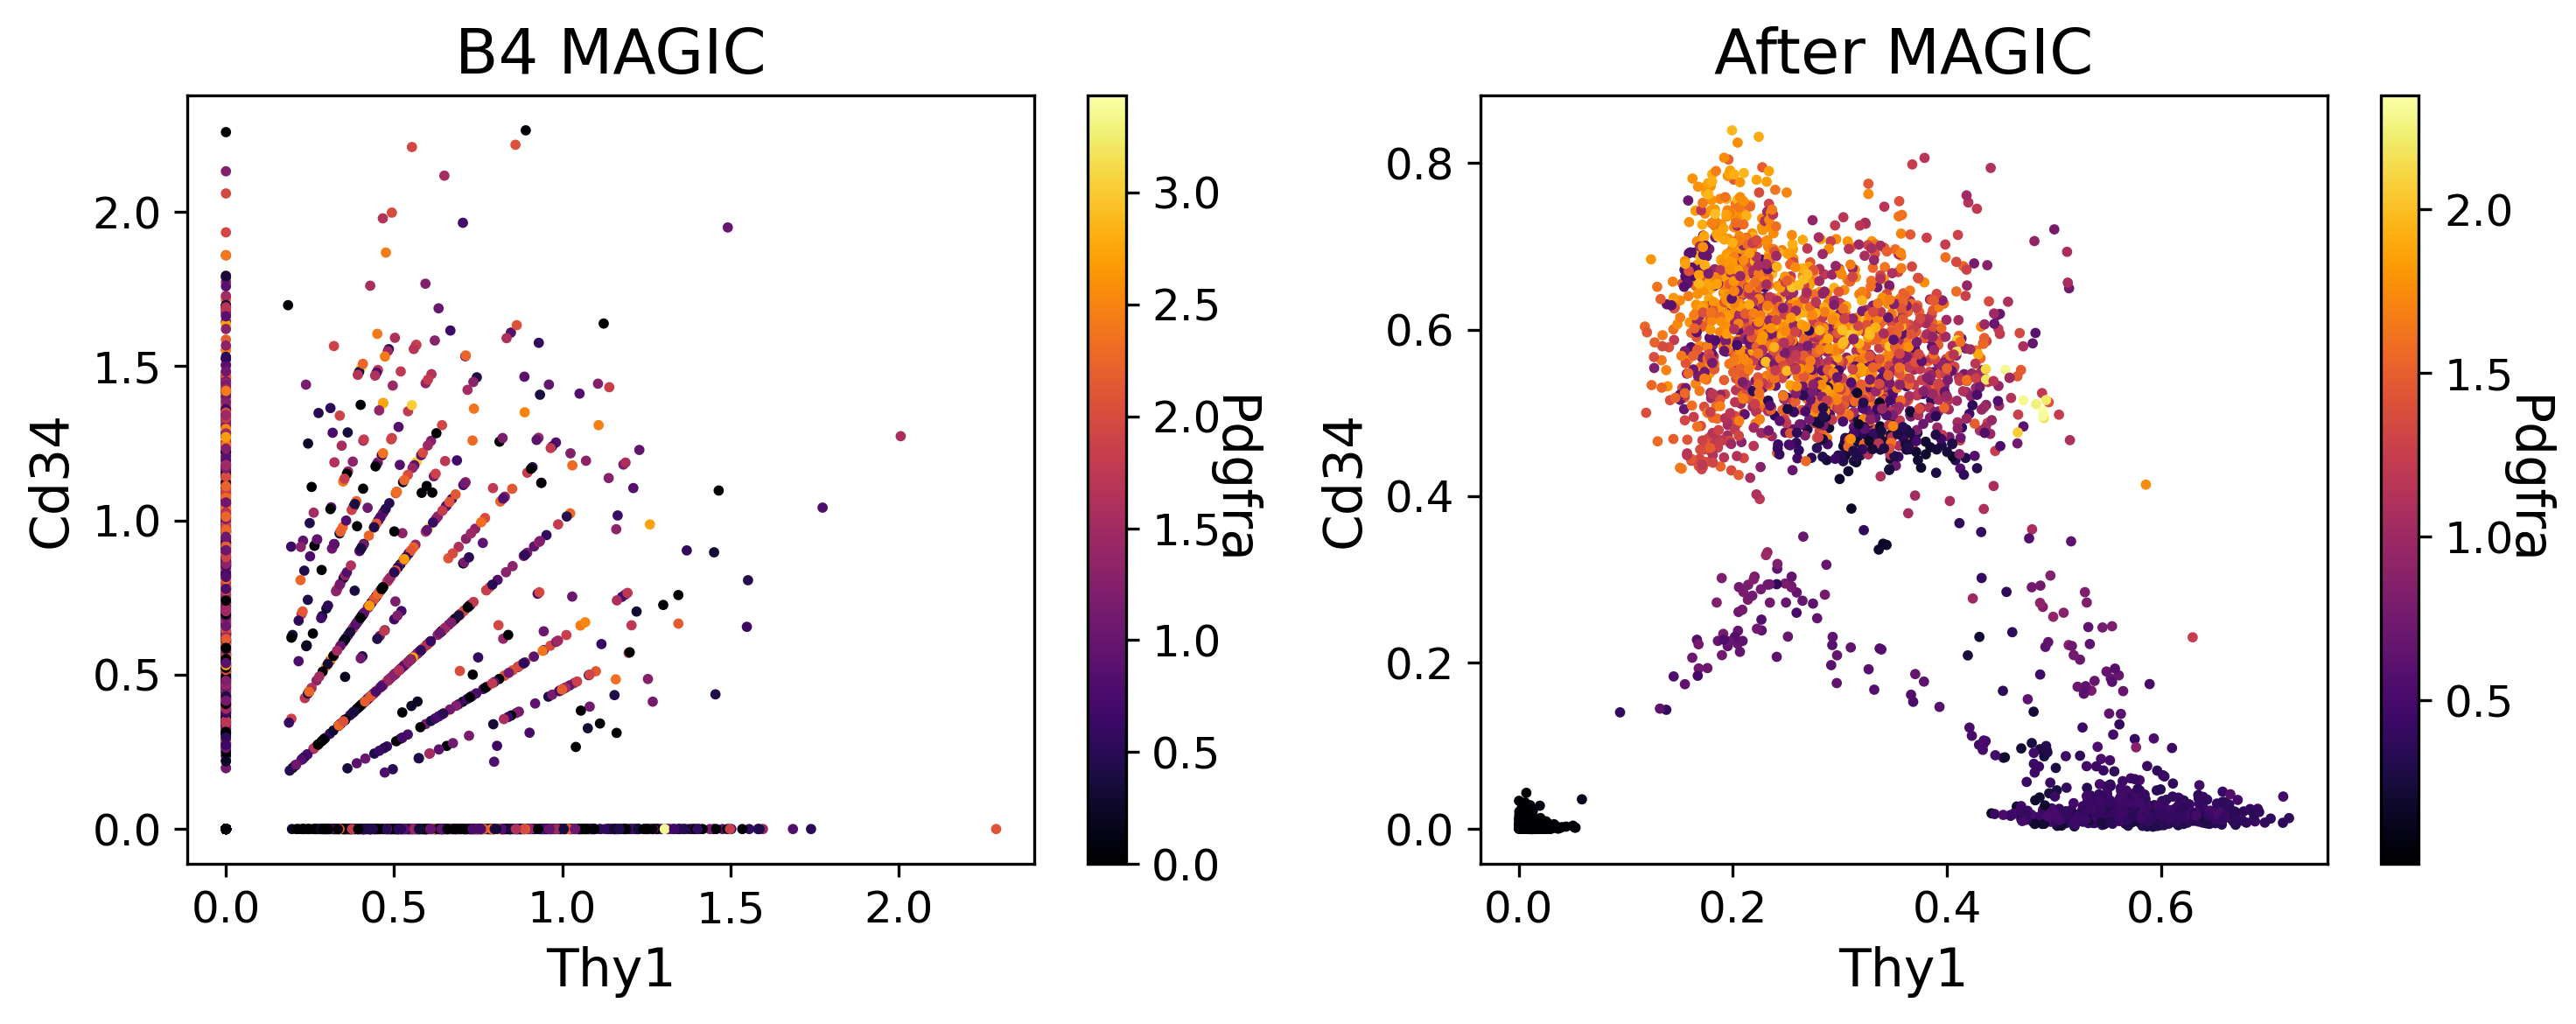

In [68]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq.to_df(layer="logcounts")["Thy1"], y=dRnaSeq.to_df(layer="logcounts")["Cd34"], c=dRnaSeq.to_df(layer="logcounts")["Pdgfra"],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq["Thy1"], y=dMagicRnaSeq["Cd34"], c=dMagicRnaSeq["Pdgfra"],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

Now, let's create a dataframe where gene expression values have been scalled row-wise (might be useful for the first DEMD approach, for wich we would need the gene expression arrays to summ up to the same value across all cells).

We can apply this scalling by computing the total sum of values for each row and then dividing the expression values for each gene in that cell by that sum.

In [69]:
help(pd.DataFrame.sum)

Help on function sum in module pandas.core.generic:

sum(self, axis=None, skipna=None, level=None, numeric_only=None, min_count=0, **kwargs)
    Return the sum of the values over the requested axis.
    
    This is equivalent to the method ``numpy.sum``.
    
    Parameters
    ----------
    axis : {index (0), columns (1)}
        Axis for the function to be applied on.
    skipna : bool, default True
        Exclude NA/null values when computing the result.
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a Series.
    numeric_only : bool, default None
        Include only float, int, boolean columns. If None, will attempt to use
        everything, then use only numeric data. Not implemented for Series.
    min_count : int, default 0
        The required number of valid values to perform the operation. If fewer than
        ``min_count`` non-NA values are present the result will b

In [70]:
%%time
#Cell-scalled GEX:
dScalRnaSeq = dMagicRnaSeq.div(dMagicRnaSeq.sum(axis=1), axis=0)
dScalRnaSeq

CPU times: user 312 ms, sys: 160 ms, total: 472 ms
Wall time: 472 ms


,Xkr4,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Alkal1,Rrs1,Adhfe1,...,mt-Co2,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb
WT__AAACCCACAGCTTCCT-1,0.000000e+00,0.000226,0.000044,0.000194,6.221024e-08,0.000097,0.000102,2.553759e-05,0.000134,1.070798e-04,...,0.000014,0.000114,0.000076,0.000059,0.000149,0.000015,0.000880,0.000303,0.000029,0.001342
WT__AAACCCAGTTCGAGCC-1,0.000000e+00,0.000223,0.000047,0.000205,1.308579e-09,0.000109,0.000100,1.609119e-05,0.000149,7.786600e-05,...,0.000014,0.000123,0.000075,0.000046,0.000149,0.000015,0.000832,0.000281,0.000026,0.001292
WT__AAACGAAAGAAGGATG-1,0.000000e+00,0.000204,0.000041,0.000160,1.263683e-08,0.000086,0.000095,2.722375e-05,0.000123,1.011470e-04,...,0.000012,0.000110,0.000081,0.000058,0.000138,0.000024,0.000864,0.000315,0.000020,0.001330
WT__AAACGAAAGGAAAGGT-1,0.000000e+00,0.000151,0.000183,0.000084,1.127641e-06,0.000072,0.000073,0.000000e+00,0.000012,0.000000e+00,...,0.000025,0.000090,0.000066,0.000085,0.000049,0.000004,0.000745,0.000343,0.000013,0.001030
WT__AAACGAAAGTTAACGA-1,5.059488e-07,0.000240,0.000117,0.000117,3.985495e-06,0.000053,0.000052,5.828104e-07,0.000039,3.719183e-07,...,0.000017,0.000080,0.000062,0.000047,0.000019,0.000013,0.000694,0.000258,0.000020,0.001173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.000000e+00,0.000194,0.000083,0.000209,7.323721e-06,0.000155,0.000053,5.097842e-09,0.000032,6.447248e-08,...,0.000025,0.000059,0.000033,0.000031,0.000037,0.000002,0.000488,0.000302,0.000033,0.000846
WT__TTTGGTTTCCGTAGTA-1,0.000000e+00,0.000197,0.000055,0.000179,3.356482e-08,0.000084,0.000111,2.422668e-05,0.000134,1.347947e-04,...,0.000017,0.000144,0.000093,0.000071,0.000153,0.000024,0.000897,0.000397,0.000024,0.001325
WT__TTTGTTGTCGCTTGAA-1,5.967135e-09,0.000153,0.000148,0.000122,1.445614e-06,0.000070,0.000078,4.890722e-08,0.000020,9.847797e-08,...,0.000021,0.000105,0.000072,0.000072,0.000029,0.000009,0.000739,0.000307,0.000023,0.001142
WT__TTTGTTGTCTGAATCG-1,0.000000e+00,0.000243,0.000048,0.000196,2.851228e-06,0.000127,0.000090,2.784758e-05,0.000111,1.062183e-05,...,0.000016,0.000102,0.000062,0.000049,0.000109,0.000012,0.000765,0.000223,0.000028,0.001235


# Approach 1-DEMD: Project cell data on gene graph

First we'll need to build and adjancency matrix from the KG. 
Then we will compute DEMD with the adjacency matrix and the distributions of 
normalised gene expression for each cell on our dataset.

## Adjacency matrix from KG

Using [networkx](https://networkx.org/documentation/stable/install.html) package.

From the integrated database, we've made a pandas dataframe that has only the 
source and target columns and then use that to make a NetworkX Graph object 
with `from_pandas_edgelist`

In [71]:
#Using 1st graph component
Gcomponents[0]

In [72]:
#Adjacency matrix: Ordered based on G.nodes()
AdjMat = networkx.to_numpy_array(Gcomponents[0])
AdjMat

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Compute Distances

Pseudocode cell below outlining the process. Will need to create a conda environment that includes the necessary packages.

In [73]:
help(DiffusionEMD.DiffusionCheb())

Help on DiffusionCheb in module DiffusionEMD.diffusion_emd object:

class DiffusionCheb(DiffusionEMD)
 |  DiffusionCheb(max_scale=10, n_scales=6, delta=0, anisotropy=1, alpha=0.5, min_basis=0, max_basis=None, method='chebyshev', use_diff_wavelets=True, cheb_order=32)
 |  
 |  Method resolution order:
 |      DiffusionCheb
 |      DiffusionEMD
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, max_scale=10, n_scales=6, delta=0, anisotropy=1, alpha=0.5, min_basis=0, max_basis=None, method='chebyshev', use_diff_wavelets=True, cheb_order=32)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fit(self, X)
 |  
 |  transform(self, y)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from DiffusionEMD:
 |  
 |  fit_transform(self, X, y, **kwargs)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from DiffusionEMD:
 |  
 |  __

In [74]:
#Reorder GEX data based on adjacency matrix and transpose to match DEMD distributions format
dScalRnaSeq = dScalRnaSeq.reindex(
                columns=list(Gcomponents[0].nodes())
                ).T
dScalRnaSeq

,WT__AAACCCACAGCTTCCT-1,WT__AAACCCAGTTCGAGCC-1,WT__AAACGAAAGAAGGATG-1,WT__AAACGAAAGGAAAGGT-1,WT__AAACGAAAGTTAACGA-1,WT__AAACGAACACCAGCTG-1,WT__AAACGAACACCGTGCA-1,WT__AAACGAACATACTTTC-1,WT__AAACGCTCACAGCCAC-1,WT__AAACGCTCATGACTAC-1,...,WT__TTTGATCGTGTTAGCT-1,WT__TTTGATCTCTCATGGA-1,WT__TTTGGAGCAACGCCCA-1,WT__TTTGGAGGTACCATAC-1,WT__TTTGGTTAGCGGGTAT-1,WT__TTTGGTTTCATTCTTG-1,WT__TTTGGTTTCCGTAGTA-1,WT__TTTGTTGTCGCTTGAA-1,WT__TTTGTTGTCTGAATCG-1,WT__TTTGTTGTCTGGGTCG-1
Tgfb1,1.406403e-04,1.239197e-04,1.502386e-04,0.000039,6.735900e-05,1.800151e-04,1.502433e-04,1.337038e-04,0.000134,1.570290e-04,...,1.601211e-04,2.859889e-05,1.645941e-04,1.664504e-04,1.384098e-04,6.990155e-05,1.338625e-04,5.151859e-05,0.000154,6.191499e-05
Tgfbr1,6.252523e-05,4.331280e-05,6.841269e-05,0.000002,2.746137e-05,5.087874e-05,8.605526e-05,6.932090e-05,0.000131,8.802600e-05,...,8.937493e-05,1.497493e-05,7.433175e-05,1.040099e-04,8.265211e-05,1.206669e-05,6.809893e-05,1.406611e-05,0.000117,3.130734e-05
Tgfbr2,1.689631e-04,1.838747e-04,1.772191e-04,0.000123,1.262158e-04,1.156940e-04,1.914937e-04,2.068003e-04,0.000093,1.603547e-04,...,1.637262e-04,1.043741e-04,1.556069e-04,1.655800e-04,1.544813e-04,9.180835e-05,1.993487e-04,1.333907e-04,0.000109,1.462934e-04
Tgfb2,1.374484e-04,1.049568e-04,9.333480e-05,0.000000,8.281672e-07,6.451425e-05,1.015640e-04,1.221827e-04,0.000030,1.010363e-04,...,9.119935e-05,2.093325e-08,1.034884e-04,7.989558e-05,1.055268e-04,9.517850e-08,1.076946e-04,2.379490e-08,0.000019,1.080826e-06
Tgfb3,5.464283e-06,5.309022e-06,1.000391e-05,0.000000,4.814783e-09,4.241659e-06,1.020456e-05,8.037885e-06,0.000013,7.006673e-06,...,1.159549e-05,0.000000e+00,8.274245e-06,8.481455e-06,1.706086e-05,0.000000e+00,9.042797e-06,0.000000e+00,0.000019,6.163838e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Efcab12,6.924702e-07,5.023543e-07,5.229601e-08,0.000000,0.000000e+00,3.080651e-09,9.211594e-08,3.668722e-07,0.000000,9.525709e-08,...,6.818209e-08,0.000000e+00,1.328645e-07,1.288951e-07,1.071041e-07,0.000000e+00,1.012580e-07,0.000000e+00,0.000000,0.000000e+00
Cic,6.594666e-05,6.008536e-05,4.863335e-05,0.000033,2.362925e-05,7.646863e-05,6.468140e-05,6.128148e-05,0.000050,6.986756e-05,...,5.396197e-05,1.642226e-05,5.579484e-05,6.829126e-05,5.725851e-05,3.131022e-05,5.911154e-05,2.849372e-05,0.000038,1.568367e-05
Mast4,2.298882e-04,1.992664e-04,2.125521e-04,0.000076,1.089306e-04,1.790972e-04,2.117776e-04,2.054985e-04,0.000207,2.496574e-04,...,2.089882e-04,8.786243e-05,2.271759e-04,2.293279e-04,2.064321e-04,8.329207e-05,2.261807e-04,8.949634e-05,0.000238,9.868715e-05
Zfp511,8.372951e-05,6.886495e-05,7.310735e-05,0.000082,1.003846e-04,7.833974e-05,8.244076e-05,7.359573e-05,0.000135,9.616492e-05,...,7.315396e-05,9.060000e-05,7.514467e-05,8.736521e-05,8.202371e-05,1.292988e-04,7.645976e-05,8.943292e-05,0.000138,9.160928e-05


As we have more datapoints (12229 genes) than distributions (3698 cells) we will use the Chebysheb approach instead of Interpolative Decomposition.

Uncomment below cell to run DEMD.

In [75]:
# DEMD = DiffusionEMD.DiffusionCheb(max_scale=4)

# embeddings = DEMD.fit_transform(X=AdjMat, y=dScalRnaSeq.to_numpy())
# #Size of DEMD embedding is n_points * n_scales
# print("Resulting object has the following dimensions\n",
#       "(rows are cell IDs ordered as in GEX data): ",embeddings.shape)

Ideally we would want a lower dimensional embedding, and this could be achieved by using the delta parameter to select subsets of points at different scales.
However, when we run the chunk below with a very low delta, the computation ends unexpectedly after using around 6x cpu resources than the above.

In [76]:
# DEMD = DiffusionEMD.DiffusionCheb(max_scale=4, delta=1e-12)

# embeddings = DEMD.fit_transform(X=AdjMat, y=dScalRnaSeq.to_numpy())
# print("Resulting object has the following dimensions\n",
#       "(rows are cell IDs ordered as in GEX data): ",embeddings.shape)

COmpute cell graphs as shown below.
Day-day, just load saved object (dist compt takes circa 30 mins).

In [77]:
# %%time

# #Cell graph: We compute the L1/cityblock distances between embeddings for each cell to get 
# #an approximation of the EMD btwn distributions
# cell_graph = scipy.spatial.distance.pdist(embeddings, metric="cityblock")
# cell_graph = scipy.spatial.distance.squareform(cell_graph)
# np.save(f"{data_dir}/cell_graph.npy", cell_graph)
# cell_graph

In [78]:
cell_graph = np.load(f"{data_dir}/cell_graph.npy")
cell_graph

array([[0.        , 0.04186841, 0.04670576, ..., 0.33735118, 0.11378763,
        0.27415729],
       [0.04186841, 0.        , 0.06998891, ..., 0.34104936, 0.12427537,
        0.2733044 ],
       [0.04670576, 0.06998891, 0.        , ..., 0.33203085, 0.10517458,
        0.27132679],
       ...,
       [0.33735118, 0.34104936, 0.33203085, ..., 0.        , 0.31358032,
        0.15060268],
       [0.11378763, 0.12427537, 0.10517458, ..., 0.31358032, 0.        ,
        0.26275185],
       [0.27415729, 0.2733044 , 0.27132679, ..., 0.15060268, 0.26275185,
        0.        ]])

Let's exlore the resulting object, which should contain distances between all of the cells as a squareform distance matrix, with zeroes in the diagonal

In [79]:
print(cell_graph.shape)

(3698, 3698)


This is essentially a cell-cell graph based on their differences on the comns KG. 
We can thus use this to get some phate embeddings or any other downstream steps.

## Downstream 

In [80]:
phate_op = phate.PHATE(knn_dist="precomputed") 
data_phate = phate_op.fit_transform(cell_graph) 

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 3698 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 3.23 seconds.
  Calculated graph and diffusion operator in 3.62 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.79 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.76 seconds.
  Calculated landmark operator in 8.13 seconds.
  Calculating optimal t...
    Automatically selected t = 40
  Calculated optimal t in 1.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.50 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.06 seconds.
Calculated PHATE in 23.10 seconds.


In [81]:
phate_op.graph

In [82]:
print(data_phate.shape)
dCellEmbeddings = pd.DataFrame(data=data_phate, index = dScalRnaSeq.columns, columns=["PHATE1","PHATE2"])
dCellEmbeddings

(3698, 2)


,PHATE1,PHATE2
WT__AAACCCACAGCTTCCT-1,-0.016706,-0.005010
WT__AAACCCAGTTCGAGCC-1,-0.016366,-0.008795
WT__AAACGAAAGAAGGATG-1,-0.016346,-0.002025
WT__AAACGAAAGGAAAGGT-1,0.025814,0.009544
WT__AAACGAAAGTTAACGA-1,0.032445,0.000113
...,...,...
WT__TTTGGTTTCATTCTTG-1,0.028484,0.007110
WT__TTTGGTTTCCGTAGTA-1,-0.015639,-0.001861
WT__TTTGTTGTCGCTTGAA-1,0.029653,0.004613
WT__TTTGTTGTCTGAATCG-1,-0.011459,0.012484


<AxesSubplot: title={'center': 'Cells on communication KG (col=clust)'}, xlabel='PHATE1', ylabel='PHATE2'>

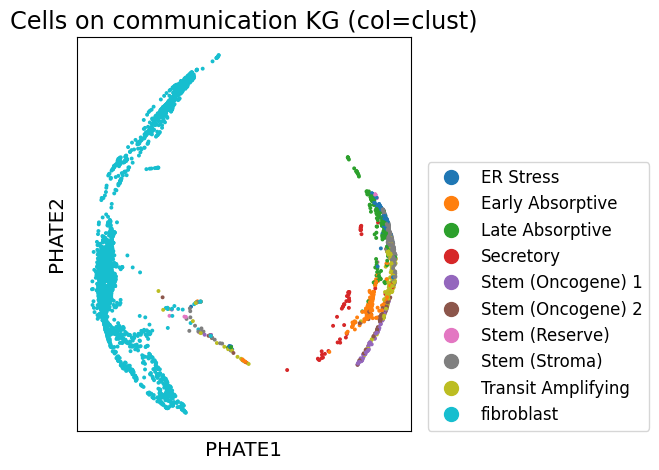

In [83]:
scprep.plot.scatter2d(
    dCellEmbeddings, c=dRnaSeq.obs.finalPOPS,
    title="Cells on communication KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))

## Scrambled graphs

Validate results from above by scrambling the KG (as it could be that the PHATE topology from the plot above results just from differential gene expression and would arise with any random set of genes/edges).

A part from a random edge permutation, we could also try building a similarly sized graph with random genes and with random edges and see how that fares.

In [84]:
print(AdjMat)
dScramE = dScalRnaSeq.reindex(np.random.permutation(list(Gcomponents[0].nodes())))
dScramE

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


,WT__AAACCCACAGCTTCCT-1,WT__AAACCCAGTTCGAGCC-1,WT__AAACGAAAGAAGGATG-1,WT__AAACGAAAGGAAAGGT-1,WT__AAACGAAAGTTAACGA-1,WT__AAACGAACACCAGCTG-1,WT__AAACGAACACCGTGCA-1,WT__AAACGAACATACTTTC-1,WT__AAACGCTCACAGCCAC-1,WT__AAACGCTCATGACTAC-1,...,WT__TTTGATCGTGTTAGCT-1,WT__TTTGATCTCTCATGGA-1,WT__TTTGGAGCAACGCCCA-1,WT__TTTGGAGGTACCATAC-1,WT__TTTGGTTAGCGGGTAT-1,WT__TTTGGTTTCATTCTTG-1,WT__TTTGGTTTCCGTAGTA-1,WT__TTTGTTGTCGCTTGAA-1,WT__TTTGTTGTCTGAATCG-1,WT__TTTGTTGTCTGGGTCG-1
Deaf1,2.080619e-05,1.171331e-05,6.598946e-06,1.934743e-05,1.167553e-05,2.391370e-06,1.093325e-05,1.263870e-05,0.000012,1.100049e-05,...,5.006113e-06,2.191194e-05,7.747160e-06,1.045596e-05,5.515763e-06,9.046177e-06,7.630863e-06,2.042259e-05,0.000010,1.321015e-05
Zfp420,5.620020e-06,5.733863e-06,6.307202e-06,5.737037e-09,2.629761e-07,7.010561e-06,6.230958e-06,3.876258e-06,0.000003,5.953358e-06,...,4.243777e-06,5.979299e-07,7.117600e-06,4.518798e-06,5.680410e-06,0.000000e+00,1.052848e-05,2.821807e-07,0.000003,5.385767e-08
Dnajc13,5.601553e-05,6.558215e-05,6.359494e-05,4.971131e-05,3.556647e-05,5.082153e-05,7.722421e-05,6.874031e-05,0.000056,6.769208e-05,...,5.525291e-05,4.863396e-05,6.041184e-05,5.585097e-05,5.882267e-05,3.832308e-05,6.765455e-05,3.925836e-05,0.000049,3.362679e-05
Rbm15b,2.671334e-05,3.403428e-05,2.845489e-05,1.094127e-05,2.257997e-05,3.520394e-05,3.462513e-05,3.089603e-05,0.000026,3.788705e-05,...,3.596053e-05,2.188585e-05,2.933467e-05,3.269368e-05,3.639787e-05,2.337620e-05,2.970483e-05,1.776895e-05,0.000028,2.547412e-05
Sfpq,2.786176e-04,3.216886e-04,2.070218e-04,1.019170e-04,1.381995e-04,2.809100e-04,2.258803e-04,2.206496e-04,0.000170,2.340862e-04,...,1.770364e-04,1.495442e-04,2.311896e-04,2.235736e-04,1.918909e-04,6.658972e-05,2.614690e-04,9.460215e-05,0.000189,1.603848e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pomc,1.178466e-05,1.344920e-05,1.771206e-05,0.000000e+00,1.202882e-07,1.653038e-05,1.403807e-05,1.501747e-05,0.000010,1.756629e-05,...,1.646977e-05,0.000000e+00,1.366213e-05,1.390223e-05,1.844512e-05,1.617438e-08,1.570798e-05,0.000000e+00,0.000006,3.025398e-07
Prl2c3,4.784559e-06,3.333535e-06,6.662252e-06,7.469479e-04,1.918400e-04,1.120987e-06,3.569228e-06,3.926307e-06,0.000007,7.507646e-06,...,5.746978e-06,2.492935e-05,4.401016e-06,7.351360e-06,4.530789e-06,1.580205e-04,3.994248e-06,3.250122e-04,0.000011,1.504590e-04
Pcm1,1.623177e-04,1.643945e-04,1.253226e-04,8.249955e-05,8.320087e-05,1.684427e-04,1.713302e-04,1.513502e-04,0.000136,1.523552e-04,...,1.378804e-04,9.505420e-05,1.446441e-04,1.528666e-04,1.489058e-04,1.326940e-04,1.445937e-04,1.026989e-04,0.000132,6.840236e-05
Asb13,2.942146e-05,1.998298e-05,2.580384e-05,6.594782e-06,3.349673e-05,1.998254e-05,2.529835e-05,3.039190e-05,0.000023,3.380921e-05,...,1.916107e-05,7.396289e-05,1.909694e-05,3.199267e-05,2.262014e-05,5.799659e-06,2.912774e-05,3.747407e-05,0.000033,5.078856e-05


In [85]:
dScramE.to_numpy()

array([[2.08061933e-05, 1.17133090e-05, 6.59894634e-06, ...,
        2.04225862e-05, 9.62448651e-06, 1.32101542e-05],
       [5.62002018e-06, 5.73386288e-06, 6.30720246e-06, ...,
        2.82180727e-07, 3.13625276e-06, 5.38576676e-08],
       [5.60155274e-05, 6.55821498e-05, 6.35949358e-05, ...,
        3.92583580e-05, 4.91446483e-05, 3.36267931e-05],
       ...,
       [1.62317686e-04, 1.64394521e-04, 1.25322638e-04, ...,
        1.02698871e-04, 1.32209992e-04, 6.84023567e-05],
       [2.94214569e-05, 1.99829843e-05, 2.58038398e-05, ...,
        3.74740712e-05, 3.25739282e-05, 5.07885627e-05],
       [7.95036775e-08, 2.09590903e-08, 4.82394403e-08, ...,
        2.11609566e-08, 1.04694439e-05, 1.28238643e-08]])

In [86]:
dScalRnaSeq.to_numpy()

array([[1.40640349e-04, 1.23919694e-04, 1.50238637e-04, ...,
        5.15185917e-05, 1.53509670e-04, 6.19149925e-05],
       [6.25252318e-05, 4.33127952e-05, 6.84126891e-05, ...,
        1.40661050e-05, 1.16957419e-04, 3.13073380e-05],
       [1.68963138e-04, 1.83874667e-04, 1.77219122e-04, ...,
        1.33390681e-04, 1.08793717e-04, 1.46293383e-04],
       ...,
       [2.29888176e-04, 1.99266393e-04, 2.12552080e-04, ...,
        8.94963405e-05, 2.38427277e-04, 9.86871464e-05],
       [8.37295121e-05, 6.88649498e-05, 7.31073531e-05, ...,
        8.94329224e-05, 1.37579682e-04, 9.16092752e-05],
       [2.32190983e-05, 2.48796021e-05, 2.40858885e-05, ...,
        1.29872932e-04, 3.08392489e-05, 3.91741961e-05]])

Uncomment below cell to run DEMD with scrambled data

In [87]:
# embeddings_scram = DEMD.fit_transform(X=AdjMat, y=dScramE.to_numpy())
# #Size of DEMD embedding is n_points * n_scales
# print("Resulting object has the following dimensions\n",
#       "(rows are cell IDs ordered as in GEX data): ",embeddings_scram.shape)

In [88]:
# %%time

# #Cell graph: THis one takes around 1h 15 min!s
# cell_graph_scram = scipy.spatial.distance.pdist(embeddings_scram, metric="cityblock")
# cell_graph_scram = scipy.spatial.distance.squareform(cell_graph_scram)
# np.save(f"{data_dir}/cell_graph_scram.npy", cell_graph_scram)
# cell_graph_scram

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 3698 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 3.20 seconds.
  Calculated graph and diffusion operator in 3.59 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.79 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.52 seconds.
  Calculated landmark operator in 7.87 seconds.
  Calculating optimal t...
    Automatically selected t = 44
  Calculated optimal t in 1.72 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.53 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.14 seconds.
Calculated PHATE in 22.87 seconds.


<AxesSubplot: title={'center': 'Cells on scrambled edge KG (col=clust)'}, xlabel='PHATE1', ylabel='PHATE2'>

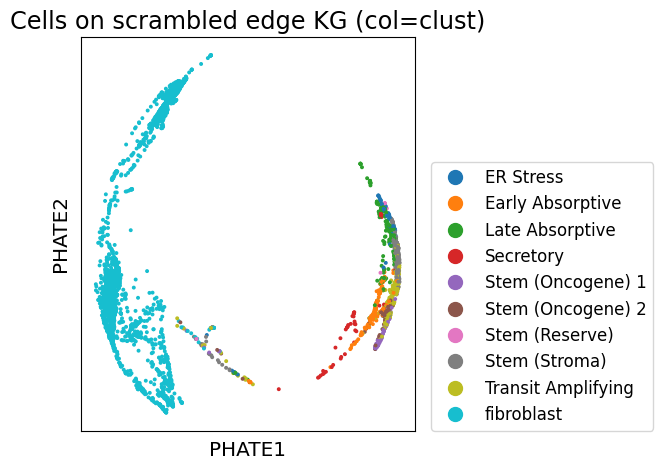

In [92]:
cell_graph_scram = np.load(f"{data_dir}/cell_graph_scram.npy")
phate_op = phate.PHATE(knn_dist="precomputed") 
data_phate_scram = phate_op.fit_transform(cell_graph_scram)
dScramCE = pd.DataFrame(data=data_phate_scram, index = dScramE.columns, columns=["PHATE1","PHATE2"])
scprep.plot.scatter2d(
    dScramCE, c=dRnaSeq.obs.finalPOPS,
    title="Cells on scrambled edge KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))